# BDA2 - Spark

Submission by:

- Julius Kittler (julki092)
- Maximilian Pfundstein (maxpf364)

***

# Task 1

**Note:** The code below was executed with temperature-readings.csv. The code would be exactly the same for `temperatures-big.csv`. Only the path would need to be adjusted. 

## year, station with the max, maxValue ORDER BY maxValue DESC

Reference: https://stackoverflow.com/questions/612231/how-can-i-select-rows-with-maxcolumn-value-distinct-by-another-column-in-sql

In [1]:
%%time

import pyspark
from pyspark.sql.functions import *
from pyspark.sql import SQLContext

sc = pyspark.SparkContext(appName='BDA')
sqlContext = SQLContext(sc)

# directory = "/user/x_julki/data/temperature-readings.csv" # full file on hdfs
# directory = "./input/temperature-readings_100000.csv" # small test file
directory = "./input/temperature-readings.csv" # full file locally

rdd = sc.textFile(directory)
rdd = rdd.map(lambda l: l.split(";"))
rdd = rdd.map(lambda l: (int(l[1][0:4]), int(l[0]), float(l[3])))
df = sqlContext.createDataFrame(rdd, ['year', 'station', 'temp'])
df.registerTempTable('rdd')

df = df.filter((df['year'] >= 1950) & (df['year'] <= 2014))
df_agg = df.groupBy('year').agg(max('temp').alias('maxValue')) # (year, max_temp per year)           
df_res = df.join(df_agg, (df['year'] == df_agg['year']) & (df['temp'] == df_agg['maxValue']), 'inner') # joining step
df_res = df_res.orderBy(desc('maxValue')).select([df_agg['year'], 'station','maxValue']).dropDuplicates() 

print(df_res.show(10))
sc.stop()

+----+-------+--------+
|year|station|maxValue|
+----+-------+--------+
|1975|  86200|    36.1|
|1992|  63600|    35.4|
|1994| 117160|    34.7|
|2014|  96560|    34.4|
|2010|  75250|    34.4|
|1989|  63050|    33.9|
|1982|  94050|    33.8|
|1968| 137100|    33.7|
|1966| 151640|    33.5|
|1983|  98210|    33.3|
+----+-------+--------+
only showing top 10 rows

None
CPU times: user 829 ms, sys: 335 ms, total: 1.16 s
Wall time: 11min 50s


## year, station with the min, minValue ORDER BY minValue DESC

In [2]:
%%time

import pyspark
from pyspark.sql.functions import *
from pyspark.sql import SQLContext

sc = pyspark.SparkContext(appName="BDA")
sqlContext = SQLContext(sc)

# directory = "/user/x_julki/data/temperature-readings.csv" # full file on hdfs
# directory = "./input/temperature-readings_100000.csv" # small test file
directory = "./input/temperature-readings.csv" # full file locally

rdd = sc.textFile(directory)
rdd = rdd.map(lambda l: l.split(";"))
rdd = rdd.map(lambda l: (int(l[1][0:4]), int(l[0]), float(l[3])))
df = sqlContext.createDataFrame(rdd, ['year', 'station', 'temp'])
df.registerTempTable('rdd')

df = df.filter((df['year'] >= 1950) & (df['year'] <= 2014))
df_agg = df.groupBy('year').agg(min('temp').alias('minValue')) # (year, min_temp per year)           
df_res = df.join(df_agg, (df['year'] == df_agg['year']) & (df['temp'] == df_agg['minValue']), 'inner') # joining step
df_res = df_res.orderBy(desc('minValue')).select([df_agg['year'], 'station','minValue']).dropDuplicates() 

print(df_res.show(10))
sc.stop()

+----+-------+--------+
|year|station|minValue|
+----+-------+--------+
|1990| 147270|   -35.0|
|1990| 166870|   -35.0|
|1952| 192830|   -35.5|
|1974| 166870|   -35.6|
|1974| 179950|   -35.6|
|1954| 113410|   -36.0|
|1992| 179960|   -36.1|
|1975| 157860|   -37.0|
|1972| 167860|   -37.5|
|2000| 169860|   -37.6|
+----+-------+--------+
only showing top 10 rows

None
CPU times: user 151 ms, sys: 78.2 ms, total: 230 ms
Wall time: 12min 2s


# Assignment 2

## year, month, value ORDER BY value DESC (with duplicate stations) | built-in API functions

In [3]:
%%time

import pyspark
from pyspark.sql.functions import *
from pyspark.sql import SQLContext

sc = pyspark.SparkContext(appName="BDA")
sqlContext = SQLContext(sc)

# directory = "/user/x_julki/data/temperature-readings.csv" # full file on hdfs
# directory = "./input/temperature-readings_100000.csv" # small test file
directory = "./input/temperature-readings.csv" # full file locally

rdd = sc.textFile(directory)
rdd = rdd.map(lambda l: l.split(";"))
rdd = rdd.map(lambda l: (int(l[1][0:4]), int(l[1][5:7]), int(l[0]), float(l[3])))
df = sqlContext.createDataFrame(rdd, ['year', 'month', 'station', 'temp'])
df.registerTempTable('rdd')

df = df.filter((df['year'] >= 1950) & (df['year'] <= 2014)).filter(df['temp'] > 10)
df_res = df.groupBy('year', 'month').count().withColumnRenamed('count', 'value').orderBy(desc('value'))        

print(df_res.show(10))
sc.stop()

+----+-----+------+
|year|month| value|
+----+-----+------+
|2014|    7|147681|
|2011|    7|146656|
|2010|    7|143419|
|2012|    7|137477|
|2013|    7|133657|
|2009|    7|133008|
|2011|    8|132734|
|2009|    8|128349|
|2013|    8|128235|
|2003|    7|128133|
+----+-----+------+
only showing top 10 rows

None
CPU times: user 85.6 ms, sys: 47.5 ms, total: 133 ms
Wall time: 5min 44s


## year, month, value ORDER BY value DESC (with duplicate stations) | regular SQL query

In [2]:
%%time

import pyspark
from pyspark.sql.functions import *
from pyspark.sql import SQLContext

sc = pyspark.SparkContext(appName="BDA")
sqlContext = SQLContext(sc)

# directory = "/user/x_julki/data/temperature-readings.csv" # full file on hdfs
# directory = "./input/temperature-readings_100000.csv" # small test file
directory = "./input/temperature-readings.csv" # full file locally

rdd = sc.textFile(directory)
rdd = rdd.map(lambda l: l.split(";"))
rdd = rdd.map(lambda l: (int(l[1][0:4]), int(l[1][5:7]), int(l[0]), float(l[3])))
df = sqlContext.createDataFrame(rdd, ['year', 'month', 'station', 'temp'])
df.registerTempTable('rdd')

df_res = sqlContext.sql("""SELECT year, month, count(station) as value FROM rdd 
                        WHERE year >= 1950 AND year >= 1950 AND temp > 10
                        GROUP BY year, month
                        ORDER BY value DESC""")      

print(df_res.show(10))
sc.stop()

+----+-----+------+
|year|month| value|
+----+-----+------+
|2014|    7|147681|
|2011|    7|146656|
|2010|    7|143419|
|2012|    7|137477|
|2013|    7|133657|
|2009|    7|133008|
|2011|    8|132734|
|2009|    8|128349|
|2013|    8|128235|
|2003|    7|128133|
+----+-----+------+
only showing top 10 rows

None
CPU times: user 77.6 ms, sys: 38.7 ms, total: 116 ms
Wall time: 4min 28s


## year, month, value ORDER BY value DESC (with unique stations) | built-in API functions

In [6]:
%%time

import pyspark
from pyspark.sql.functions import *
from pyspark.sql import SQLContext

sc = pyspark.SparkContext(appName="BDA")
sqlContext = SQLContext(sc)

# directory = "/user/x_julki/data/temperature-readings.csv" # full file on hdfs
# directory = "./input/temperature-readings_100000.csv" # small test file
directory = "./input/temperature-readings.csv" # full file locally

rdd = sc.textFile(directory)
rdd = rdd.map(lambda l: l.split(";"))
rdd = rdd.map(lambda l: (int(l[1][0:4]), int(l[1][5:7]), int(l[0]), float(l[3])))
df = sqlContext.createDataFrame(rdd, ['year', 'month', 'station', 'temp'])
df.registerTempTable('rdd')

df = df.filter((df['year'] >= 1950) & (df['year'] <= 2014)).filter(df['temp'] > 10)
df_res = df.groupBy('year', 'month', 'station').count().groupBy('year', 'month').count()
df_res = df_res.withColumnRenamed('count', 'value').orderBy(desc('value'))       

print(df_res.show(10))
sc.stop()

+----+-----+-----+
|year|month|value|
+----+-----+-----+
|1972|   10|  378|
|1973|    6|  377|
|1973|    5|  377|
|1972|    8|  376|
|1973|    9|  376|
|1972|    5|  375|
|1972|    6|  375|
|1971|    8|  375|
|1972|    9|  375|
|1971|    9|  374|
+----+-----+-----+
only showing top 10 rows

None
CPU times: user 103 ms, sys: 48.7 ms, total: 152 ms
Wall time: 5min 53s


## year, month, value ORDER BY value DESC (with unique stations) | regular SQL query

In [3]:
%%time

import pyspark
from pyspark.sql.functions import *
from pyspark.sql import SQLContext

sc = pyspark.SparkContext(appName="BDA")
sqlContext = SQLContext(sc)

# directory = "/user/x_julki/data/temperature-readings.csv" # full file on hdfs
# directory = "./input/temperature-readings_100000.csv" # small test file
directory = "./input/temperature-readings.csv" # full file locally

rdd = sc.textFile(directory)
rdd = rdd.map(lambda l: l.split(";"))
rdd = rdd.map(lambda l: (int(l[1][0:4]), int(l[1][5:7]), int(l[0]), float(l[3])))
df = sqlContext.createDataFrame(rdd, ['year', 'month', 'station', 'temp'])
df.registerTempTable('rdd')

df_res = sqlContext.sql("""SELECT year, month, count(DISTINCT station) as value FROM rdd 
                        WHERE year >= 1950 AND year >= 1950 AND temp > 10
                        GROUP BY year, month
                        ORDER BY value DESC""")      

print(df_res.show(10))
sc.stop()

+----+-----+-----+
|year|month|value|
+----+-----+-----+
|1972|   10|  378|
|1973|    6|  377|
|1973|    5|  377|
|1973|    9|  376|
|1972|    8|  376|
|1972|    6|  375|
|1971|    8|  375|
|1972|    9|  375|
|1972|    5|  375|
|1972|    7|  374|
+----+-----+-----+
only showing top 10 rows

None
CPU times: user 95.1 ms, sys: 55.8 ms, total: 151 ms
Wall time: 5min 45s


# Assignment 3

## year, month, station, avgMonthlyTemperature ORDER BY avgMonthlyTemperature DESC

In [1]:
%%time

import pyspark
from pyspark.sql.functions import *
from pyspark.sql import SQLContext

sc = pyspark.SparkContext(appName="BDA")
sqlContext = SQLContext(sc)

# directory = "/user/x_julki/data/temperature-readings.csv" # full file on hdfs
# directory = "./input/temperature-readings_100000.csv" # small test file
directory = "./input/temperature-readings.csv" # full file locally

rdd = sc.textFile(directory)
rdd = rdd.map(lambda l: l.split(";"))
rdd = rdd.map(lambda l: (int(l[1][0:4]), int(l[1][5:7]), int(l[1][8:10]), int(l[0]), float(l[3])))
df = sqlContext.createDataFrame(rdd, ['year', 'month', 'day', 'station', 'temp'])
df.registerTempTable('rdd')

df = df.filter((df['year'] >= 1960) & (df['year'] <= 2014))
df_res = df.groupBy('year', 'month', 'station', 'day').agg(((min('temp') + max('temp'))/2).alias('avgDailyTemperature'))
df_res = df_res.groupBy('year', 'month', 'station').agg(mean('avgDailyTemperature').alias('avgMonthlyTemperature'))
df_res = df_res.select(['year', 'month', 'station', 'avgMonthlyTemperature']).orderBy(desc('avgMonthlyTemperature'))       

print(df_res.show(10))
sc.stop()

+----+-----+-------+---------------------+
|year|month|station|avgMonthlyTemperature|
+----+-----+-------+---------------------+
|2014|    7|  96000|                 26.3|
|1994|    7|  96550|   23.071052631578947|
|1983|    8|  54550|                 23.0|
|1994|    7|  78140|   22.970967741935485|
|1994|    7|  85280|   22.872580645161293|
|1994|    7|  75120|    22.85806451612903|
|1994|    7|  65450|    22.85645161290322|
|1994|    7|  96000|    22.80806451612904|
|1994|    7|  95160|    22.76451612903226|
|1994|    7|  86200|    22.71129032258064|
+----+-----+-------+---------------------+
only showing top 10 rows

None
CPU times: user 752 ms, sys: 282 ms, total: 1.03 s
Wall time: 6min 56s


# Assignment 4

In [1]:
%%time

import pyspark
from pyspark.sql.functions import *
from pyspark.sql import SQLContext

sc = pyspark.SparkContext(appName="BDA")
sqlContext = SQLContext(sc)

# temperature-readings ---------------------------------------------------------------------------

# directory = "/user/x_julki/data/temperature-readings.csv" # full file on hdfs
directory = "./input/temperature-readings_100000.csv" # small test file
# directory = "./input/temperature-readings.csv" # full file locally

rdd = sc.textFile(directory)
rdd = rdd.map(lambda l: l.split(";"))
rdd = rdd.map(lambda l: (int(l[0]), float(l[3])))
df_temp = sqlContext.createDataFrame(rdd, ['station', 'temp'])
df_temp.registerTempTable('rdd')

df_temp = df_temp.groupBy('station').agg(max('temp').alias('maxTemp'))
df_temp = df_temp.filter((df_temp['maxTemp'] >= 25) & (df_temp['maxTemp'] <= 30))

# precipitation-readings --------------------------------------------------------------------------

# directory = "/user/x_julki/data/precipitation-readings.csv" # full file on hdfs
directory = "./input/precipitation-readings_1000000.csv" # small test file
# directory = "./input/precipitation-readings.csv" # full file locally

rdd = sc.textFile(directory)
rdd = rdd.map(lambda l: l.split(";"))
rdd = rdd.map(lambda l: (str(l[1][0:10]), int(l[0]), float(l[3])))
df_prec = sqlContext.createDataFrame(rdd, ['date', 'station', 'prec'])
df_prec.registerTempTable('rdd')

df_prec = df_prec.groupBy('station', 'date').agg(max('prec').alias('maxDailyPrec'))
df_prec = df_prec.groupBy('station').agg(min('maxDailyPrec').alias('min_maxDailyPrec'), max('maxDailyPrec').alias('max_maxDailyPrec'))
df_prec = df_prec.filter((df_prec['min_maxDailyPrec'] >= 100) & (df_prec['max_maxDailyPrec'] <= 200))
df_prec = df_prec.withColumnRenamed('max_maxDailyPrec', 'maxDailyPrecipitation').select(['station', 'maxDailyPrecipitation'])

# join --------------------------------------------------------------------------------------------

df_res = df_prec.join(df_temp, df_prec['station'] == df_temp['station'], 'inner')
df_res = df_res.select([df_temp['station'], 'maxTemp','maxDailyPrecipitation']).orderBy(desc('station'))

print(df_res.show(10))
sc.stop()

+-------+-------+---------------------+
|station|maxTemp|maxDailyPrecipitation|
+-------+-------+---------------------+
+-------+-------+---------------------+

None
CPU times: user 723 ms, sys: 275 ms, total: 998 ms
Wall time: 33.8 s


# Assignment 5

In [1]:
%%time

import pyspark
from pyspark.sql.functions import *
from pyspark.sql import SQLContext

sc = pyspark.SparkContext(appName="BDA")
sqlContext = SQLContext(sc)

# stations-Ostergotland ---------------------------------------------------------------------------

# directory = "/user/x_julki/data/stations-Ostergotland.csv" # full file on hdfs
directory = "./input/stations-Ostergotland.csv" # full file locally

rdd = sc.textFile(directory)
rdd = rdd.map(lambda l: l.split(";"))
rdd = rdd.map(lambda l: (int(l[0]),))

df_oster = sqlContext.createDataFrame(rdd, ['station'])
df_oster.registerTempTable('rdd')

df_oster = df_oster.distinct()

# precipitation-readings --------------------------------------------------------------------------

# directory = "/user/x_julki/data/precipitation-readings.csv" # full file on hdfs
# directory = "./input/precipitation-readings_1000000.csv" # small test file
directory = "./input/precipitation-readings.csv" # full file locally

rdd = sc.textFile(directory)
rdd = rdd.map(lambda l: l.split(";"))
rdd = rdd.map(lambda l: (int(l[1][0:4]), int(l[1][5:7]), int(l[0]), float(l[3])))
df_prec = sqlContext.createDataFrame(rdd, ['year', 'month', 'station', 'prec'])
df_prec.registerTempTable('rdd')

df_prec = df_prec.filter((df_prec['year'] >= 1993) & (df_prec['year'] <= 2016))

# join --------------------------------------------------------------------------------------------

df_res = df_oster.join(df_prec, df_prec['station'] == df_oster['station'], 'inner').drop(df_prec['station'])
df_res = df_res.groupBy(['year', 'month', 'station']).agg(sum('prec').alias('totMonthlyPrecByStation'))
df_res = df_res.groupBy(['year', 'month']).agg(mean('totMonthlyPrecByStation').alias('avgMonthlyPrecipitation'))
df_res = df_res.select(['year', 'month','avgMonthlyPrecipitation']).orderBy(desc('year'), desc('month'))

print(df_res.show(10))
sc.stop()

+----+-----+-----------------------+
|year|month|avgMonthlyPrecipitation|
+----+-----+-----------------------+
|2016|    7|                    0.0|
|2016|    6|                47.6625|
|2016|    5|     29.250000000000007|
|2016|    4|     26.900000000000006|
|2016|    3|     19.962500000000002|
|2016|    2|                21.5625|
|2016|    1|     22.325000000000003|
|2015|   12|                 28.925|
|2015|   11|      63.88750000000001|
|2015|   10|                 2.2625|
+----+-----+-----------------------+
only showing top 10 rows

None
CPU times: user 716 ms, sys: 266 ms, total: 982 ms
Wall time: 1min 39s


# Assignment 6

In [1]:
%%time

import pyspark
from pyspark.sql.functions import *
from pyspark.sql import SQLContext

sc = pyspark.SparkContext(appName="BDA")
sqlContext = SQLContext(sc)


# stations-Ostergotland ---------------------------------------------------------------------------

# directory = "/user/x_julki/data/stations-Ostergotland.csv" # full file on hdfs
directory = "./input/stations-Ostergotland.csv" # full file locally

rdd = sc.textFile(directory)
rdd = rdd.map(lambda l: l.split(";"))
rdd = rdd.map(lambda l: (int(l[0]),))

df_oster = sqlContext.createDataFrame(rdd, ['station'])
df_oster.registerTempTable('rdd')

df_oster = df_oster.distinct()


# temperature-readings ---------------------------------------------------------------------------

# directory = "/user/x_julki/data/temperature-readings.csv" # full file on hdfs
# directory = "./input/temperature-readings_100000.csv" # small test file
directory = "./input/temperature-readings.csv" # full file locally

rdd = sc.textFile(directory)
rdd = rdd.map(lambda l: l.split(";"))
rdd = rdd.map(lambda l: (int(l[1][0:4]), int(l[1][5:7]), int(l[1][8:10]), int(l[0]), float(l[3])))
df_temp = sqlContext.createDataFrame(rdd, ['year', 'month', 'day', 'station', 'temp'])
df_temp.registerTempTable('rdd')

df_temp = df_temp.filter((df_temp['year'] >= 1950) & (df_temp['year'] <= 2014))

# longterm (1950-1980) ----------------------------------------------------------------------------

df_full = df_oster.join(df_temp, df_temp['station'] == df_oster['station'], 'inner').drop(df_temp['station'])

df_full = df_full.groupBy('year', 'month', 'station', 'day').agg(((min('temp') + max('temp'))/2).alias('avgDailyTemperatureByYearByStation'))
df_full = df_full.groupBy('year', 'month', 'station').agg(mean('avgDailyTemperatureByYearByStation').alias('avgMonthlyTemperatureByYearByStation'))
df_full = df_full.groupBy('year', 'month').agg(mean('avgMonthlyTemperatureByYearByStation').alias('avgMonthlyTemperatureByYear'))

df_longterm = df_full.filter((df_full['year'] >= 1950) & (df_full['year'] <= 1980))

df_longterm = df_longterm.groupBy('month').agg(mean('avgMonthlyTemperatureByYear').alias('avgMonthlyTemperature_longterm'))


# difference (1950-2014) --------------------------------------------------------------------------

df_res = df_full.join(df_longterm, df_full['month'] == df_longterm['month'], 'inner').drop(df_longterm['month'])

df_res = df_res.withColumn('difference', col('avgMonthlyTemperature_longterm') - col('avgMonthlyTemperatureByYear'))
df_res = df_res.select(['year', 'month', 'difference']).orderBy(desc('year'), desc('month'))
df_res.coalesce(1).write.csv('BDA2_Asg6.csv')
                                            
print(df_res.show(10))
# sc.stop()

+----+-----+--------------------+
|year|month|          difference|
+----+-----+--------------------+
|2014|   12|  -0.823889353795701|
|2014|   11| -2.0635396726928983|
|2014|   10| -1.5225549840378143|
|2014|    9|-0.06105818643721...|
|2014|    8|  0.6426470719706945|
|2014|    7|  -2.093910775893086|
|2014|    6|  1.8073686197315233|
|2014|    5|-0.26719065014069976|
|2014|    4|  -2.066193158991547|
|2014|    3| -4.4867483435745665|
+----+-----+--------------------+
only showing top 10 rows

None
CPU times: user 1.02 s, sys: 466 ms, total: 1.49 s
Wall time: 22min 34s


**Plotting the difference**

In [2]:
# Prepare data for plot
import matplotlib
import pandas as pd

df = pd.read_csv("BDA2_Asg6.csv/part-00000-33e3a2af-e5eb-4080-8725-8d131edbd6a8-c000.csv", index_col=None, header=None)
df.columns = ['year', 'month', 'difference']
# df = df.iloc[::-1]
df = df.apply(pd.to_numeric) # convert all columns of DataFrame to numeric
df.head()

,year,month,difference
0,2014,12,-0.823889
1,2014,11,-2.063540
2,2014,10,-1.522555
3,2014,9,-0.061058
4,2014,8,0.642647


In [3]:
# Difference by Year-Month
df['date'] = df['year'].map(str) + "-" + df['month'].map(str)
df.plot.line(x = 'date', y = 'difference', figsize=(15,10), title = "Difference by Year-Month");

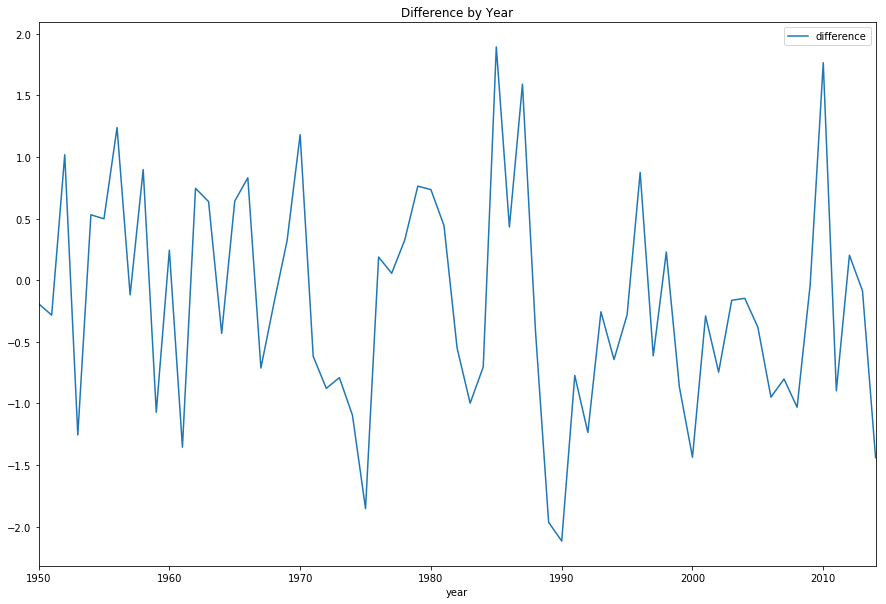

In [4]:
# Difference by Year
df2 = df.groupby(['year'])['difference'].mean().to_frame()
df2.reset_index(level=0, inplace=True)
df2.plot.line(x = 'year', y = 'difference', figsize=(15,10), title = "Difference by Year");

**Comment:** It does not seem like there is a trend across years (and neither across dates) which makes sense since we don’t expect any temperature changes in the long-term. However, we can observe that there were some years with especially large (e.g. 1990) and especially small temperature differences (e.g. 1985). Hence, the differences may vary noticeably from year to year.

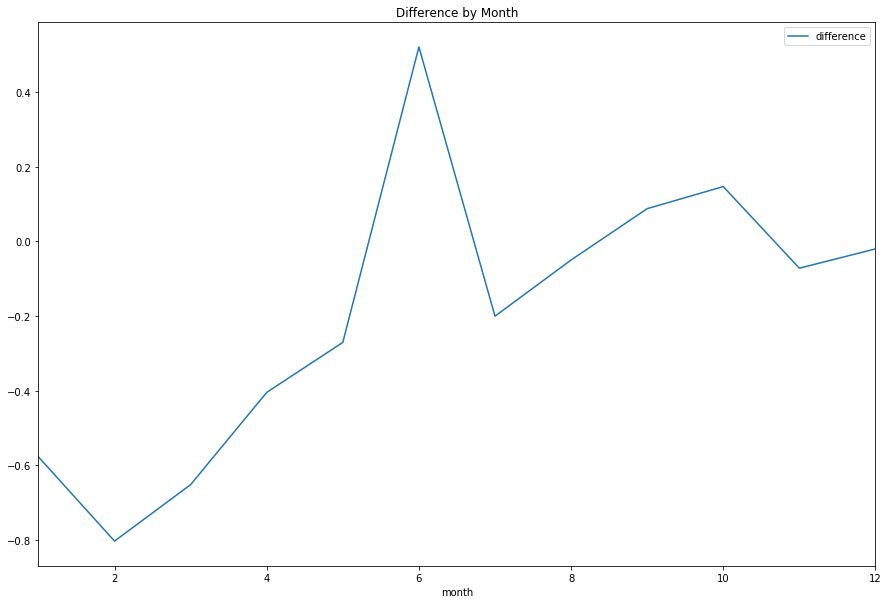

In [6]:
# Difference by Month
df3 = df.groupby(['month'])['difference'].mean().to_frame()
df3.reset_index(level=0, inplace=True)
df3.plot.line(x = 'month', y = 'difference', figsize=(15,10), title = "Difference by Month");

**Comment:** We can see that the differences in temperature are negative in the winter months and positive in the summer months (see “Difference by Month” plot). This makes sense since we computed the difference as: Difference = General - Östergotland. We expect Östergotland to have warmer temperatures in general than more northern parts of Sweden in the Winter period (but still negative temperatures) because Östergotland is in the south. Our expectation is fulfilled.